# This notebooks does predictive modeling of the Output : "Is there any potential Microbial Activity?" in the FSHA form 
# This notebook applies basic ML techniques like NaiveBayesClassifier, LogisticRegression, SGDClassifier on the concatenated text derived from the set of features. The text is cleaned, normalized and then vectorized and fit into the Model. The target is upsampled to counter the unbalanced data ('Yes' / 'No' values), before applying ML

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
#filename = "C:/Pepsico/FSHA RPA - 25 July 2019 - 209Files.xlsm"
filename1 = "C:/Pepsico/NAF-2019 RPA - 09 AUGUST 2019.xlsm"
filename2 = "C:/Pepsico/NAF-2018 RPA - 09 AUGUST 2019.xlsm"
filename3 = "C:/Pepsico/Additional FSHAs.xlsm"
filename4 = "C:/Pepsico/FSHA RPA - Microbial Growth = Y - 14 Aug 2019.xlsm"
#filename5 = "C:/Pepsico/NAF - Additional FSHAs 1 - 13 AUG 2019.xlsm"

# Read the extract file, check the number of records, first few rows

In [3]:
df1 = pd.read_excel(filename1)
df2 = pd.read_excel(filename2)
df3 = pd.read_excel(filename3)
df4 = pd.read_excel(filename4)

In [4]:
df =  pd.concat([df1,df2,df3,df4])

In [5]:
len(df)

119

In [6]:
df.head()

,File Name,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,center,...,Table1_Row6_Milk,Table1_Row6_Nuts,Table1_Row6_Peanuts,Table1_Row6_Soya,Table1_Row6_Celery,Table1_Row6_Lupin,Table1_Row6_Molluscs,Table1_Row6_Mustard,Table1_Row6_Sesame Seeds,Table1_Row6_Sulphites
0,Cheetos Double Cheddar Eggs Combined FSHA Form...,Cheetos Double Cheddar Egg Puff LTO 2019,52607,Cheetos Eggs Double Cheddar flavored Puffs,Refresh,Launch a legacy Double Cheddar seasoning (ING9...,FFM0008310,Ann Robarge,FLNA,Plano,...,0,0,0,0,0,0,0,0,0,0
1,Cheetos Popcorn Combined FSHA Fast Track -Flam...,Cheetos Popcorn 2020,53939,Cheetos Popcorn - Flamin' Hot,Reframe,Launch new Flamin' Hot seasoning PCRN_POP - Se...,FFM0008419,Ann Robarge,FLNA,Plano,...,0,0,0,0,0,0,0,0,0,0
2,Cheetos Popcorn Combined FSHA Fast Track- Mell...,Cheetos Popcorn 2020,53939,Cheetos Popcorn - Cheese,Reframe,Existing Seasoning - Powder - Mellow Chedda...,FFM0008410,Ann Robarge,FLNA,Plano,...,0,0,0,0,0,0,0,0,0,0
3,Combined FSHA LKC jalapeno productivity 022520...,LKC jalapeno seasoning productivity,none,Lays and Miss Vickies jalapeno seasoning produ...,productivity,Cost reduced seasoning - LKC jalapeno seasoni...,FFM8724,Holly Ramage x4257,FLNA,Plano,...,0,0,0,0,0,0,0,0,0,0
4,Combined FSHA RRD sweet chili and Sour Cream #...,RRD Sweet Chili and Sour Cream National Launch,54226,RRD Sweet Chili and Sour Cream Non GMO,refresh,New seasoning RRD NGM SWT CHILI SC #2 SEAS (I...,FFM0008420,Holly Ramage x4257,FLNA,plano,...,0,0,0,0,0,0,0,0,0,0


# Select key features for potentialMicrobial 

In [7]:

features_df=df[['projName', 'projDesc','formulaNumber','PDA_projName', 'CPD-ProdName-Desc','procPlat', 'intrinsicProd',
        'preservatives', 'pH', 'waterActivity', 'packaging','otherFSA','prodStorageDist', 'foodSafetyProdClaims','targetMarket','shelfLife','specificStorage']]

#Replace missing values with NA
df.fillna('NA', inplace=True)

In [8]:
#Convert all text to string and lower case, since some values are coming as float from data extract
def conv_str(x):
   
    x=str(x)
    x=x.lower()
    return (x)
features_df['projName']=features_df['projName'].apply(lambda x:conv_str(x))  
features_df['projDesc']=features_df['projDesc'].apply(lambda x:conv_str(x))  
features_df['formulaNumber']=features_df['formulaNumber'].apply(lambda x:conv_str(x))  
features_df['PDA_projName']=features_df['PDA_projName'].apply(lambda x:conv_str(x))  
features_df['CPD-ProdName-Desc']=features_df['CPD-ProdName-Desc'].apply(lambda x:conv_str(x))  
features_df['procPlat']=features_df['procPlat'].apply(lambda x:conv_str(x)) 
features_df['intrinsicProd']=features_df['intrinsicProd'].apply(lambda x:conv_str(x)) 
features_df['preservatives']=features_df['preservatives'].apply(lambda x:conv_str(x))  
features_df['pH']=features_df['pH'].apply(lambda x:conv_str(x))  
features_df['waterActivity']=features_df['waterActivity'].apply(lambda x:conv_str(x))  
features_df['packaging']=features_df['packaging'].apply(lambda x:conv_str(x))  
features_df['otherFSA']=features_df['otherFSA'].apply(lambda x:conv_str(x))  
features_df['prodStorageDist']=features_df['prodStorageDist'].apply(lambda x:conv_str(x))  
features_df['foodSafetyProdClaims']=features_df['foodSafetyProdClaims'].apply(lambda x:conv_str(x))  
features_df['targetMarket']=features_df['targetMarket'].apply(lambda x:conv_str(x))  
features_df['shelfLife']=features_df['shelfLife'].apply(lambda x:conv_str(x))  
features_df['specificStorage']=features_df['specificStorage'].apply(lambda x:conv_str(x))  

# Concatenate the columns as one single text value

In [9]:
features_df['concat_text'] = features_df['projName']+" "+features_df['projDesc']+" "+features_df['formulaNumber']+" "+features_df['PDA_projName']+" "+features_df['CPD-ProdName-Desc']+" "+features_df['procPlat']+" "+features_df['intrinsicProd']+" "+features_df['preservatives']+" "+features_df['pH']+" "+features_df['packaging']+" "+features_df['otherFSA']+" "+features_df['prodStorageDist']+" "+features_df['foodSafetyProdClaims']+" "+features_df['targetMarket']+" "+features_df['waterActivity']+" "+features_df['shelfLife']+" "+features_df['specificStorage']


# Find the number of tokens in the text

In [10]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

15059

We have over 15k words in the data.

# Find the value counts of target Field (Yes / No)

In [11]:
df.potentialMicrobial.value_counts()

No     91
Yes    22
NA      6
Name: potentialMicrobial, dtype: int64

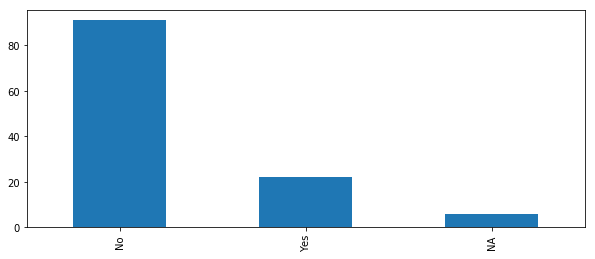

In [12]:
plt.figure(figsize=(10,4))
df.potentialMicrobial.value_counts().plot(kind='bar');

# Binarize the target, impute any missing value with the mode

In [13]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):

        if fsha_data[targetName].values[i]=='Yes':
            train_y.append(1)
        elif fsha_data[targetName].values[i]=='No':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

In [14]:
features_df["tags"] = impute_target(df,"potentialMicrobial")

# Plot the target after binarization

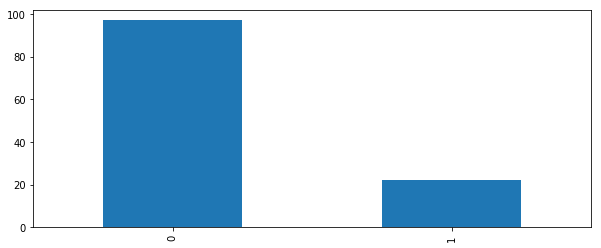

In [15]:
plt.figure(figsize=(10,4))
features_df.tags.value_counts().plot(kind='bar');

In [16]:
#Check the counts of 1 and 0 in the target
features_df.tags.value_counts()

0    97
1    22
Name: tags, dtype: int64

The classes are not balanced, but we see higher count of 1, based on new data

In [17]:
def print_plot(index):
    example = features_df[features_df.index == index][['concat_text', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

# Have a look a few concatenated text and target pairs.

In [18]:
print_plot(10)

tostitos-salsa verde salsa verde was launched in 2014 as a regional launch. revisions have been done to the 2014 recipe to include roasted tomatoes, cilantro flavor and new product is now designed for a nation wide launch.  20.32 v3 tostitos salsa verde hot fill salsa  hot fill nan n/a  ph < 4.1 glass jar and lid - hot fill n/a  ambient storage / dsd none  no high  1 year  yes, refrigerate after opening
Tag: 0


In [19]:
print_plot(5)

rrd sweet chili and sour cream new seasoning rrd ngm swt chili sc seas (ing0001937) on existing red rock deli pc base ffm0008373 rrd sweet chili and sour cream red rock deli potato chips fried potato chips - whole potatoes are peeled, sliced, kettle fried, salted or seasoned and packaged. nan none n/a since low moisture food  n/a since low moisture food none ambient; no special requirements none no low moisture food: water activity <0.3 shelf-life mode of failure is loss of flavor and texture staling; not food safety related.  no
Tag: 0


# Clean the text (remove punctuation, symbols, lowercase etc)

In [20]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
stop = stopwords.words('english')
stop.extend(['na','n', 'none'])
STOPWORDS=set(stop)

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [21]:
features_df['concat_text'] = features_df['concat_text'].apply(clean_text)

# Check a sample row of cleaned text

In [22]:
print_plot(5)

rrd sweet chili sour cream new seasoning rrd ngm swt chili sc seas ing0001937 existing red rock deli pc base ffm0008373 rrd sweet chili sour cream red rock deli potato chips fried potato chips whole potatoes peeled sliced kettle fried salted seasoned packaged nan since low moisture food since low moisture food ambient special requirements low moisture food water activity 03 shelflife mode failure loss flavor texture staling food safety related
Tag: 0


In [23]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

9441

We see 9k words after cleaning and lowercasing the text

# Train Test Split

In [24]:
len(features_df)

119

In [64]:
# We do a 80 20 split of the data into Train and Test samples. We set aside the Test samples for validation of the model
# We ensure the same distribution of the 0 and 1 is maintained in both train and test by specifying stratify=y
X = features_df.concat_text
y = features_df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state = 42)

In [65]:
len(X_train)

95

In [66]:
len(X_test)

24

In [67]:
y_train.value_counts()

0    77
1    18
Name: tags, dtype: int64

In [68]:
y_test.value_counts()

0    20
1     4
Name: tags, dtype: int64

In [69]:
y_test = y_test.reset_index()
y_test = y_test['tags']

# Upsample the target data, since the data is highly imbalanced

In [70]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_potMicrobial = X[X.tags==0]
potMicrobial = X[X.tags==1]

In [71]:
len(not_potMicrobial)

77

In [72]:
len(potMicrobial)

18

In [73]:
# upsample minority
potMicrobial_upsampled = resample(potMicrobial,
                          replace=True, # sample with replacement
                          n_samples=len(not_potMicrobial), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([potMicrobial_upsampled, not_potMicrobial])

In [74]:
# check new class counts - now we have balanced data
upsampled.tags.value_counts()

1    77
0    77
Name: tags, dtype: int64

In [75]:
y_train = upsampled.tags
X_train = upsampled.drop('tags', axis=1)

In [76]:
y_train=y_train.reshape(y_train.shape[0],1)

In [77]:
y_train.shape

(154, 1)

In [78]:
X_train.shape

(154, 1)

In [79]:
X_train['concat_text'].values[5]

'nf n3 tropicana tropicana gunaydintur change fruit juice variety tropicana gunaydintur tropicana good morning juice drink walnut flavour honey nf n3 tropicana tropicana gunaydinturlaunch new juice drink 30 juice tropicana gunaydin good morning mixed fruit drink walnut flavouring honey 01 compliance silver criteria sugar content max 5 w v nan nan titratable acidity 025 citric acid tetrapak ambient storage distribution 9 months product needs stored refrigerator consumed within 2 days package opened'

In [80]:
X_train = X_train['concat_text'].values

In [81]:
X_train[5]

'nf n3 tropicana tropicana gunaydintur change fruit juice variety tropicana gunaydintur tropicana good morning juice drink walnut flavour honey nf n3 tropicana tropicana gunaydinturlaunch new juice drink 30 juice tropicana gunaydin good morning mixed fruit drink walnut flavouring honey 01 compliance silver criteria sugar content max 5 w v nan nan titratable acidity 025 citric acid tetrapak ambient storage distribution 9 months product needs stored refrigerator consumed within 2 days package opened'

In [82]:
X_test.values[0]

'doritos ultimate cheddar ultimate cheddar ing0001142 30049403 tortilla chips ffm0008372 doritos ultimate cheddar tortilla chips doritos tortilla chips ultimate cheddar seasonings fried tortilla chips whole corn cooked alkaline soaked washed milled sheeted cut toasted fried salted seasoned packaged nan since low moisture food since low moisture food ambient special requirements low moisture food water activity 03 shelflife mode failure loss flavor texture staling food safety related'

In [44]:
X_test = X_test.values

In [61]:
X_test[0]

array([0], dtype=int64)

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

### Naive Bayes classifier for multinomial models

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [47]:
%%time
from sklearn.metrics import classification_report,f1_score
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 1.0
f1-score 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        20
          1       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00        24

Wall time: 0 ns


Let us check the index position in Actual Test samples and predicted values where the target is 1 (Yes for potential microbial)

In [48]:
print(np.where(y_test==1))

(array([ 5,  7, 13, 18], dtype=int64),)


In [49]:
print(np.where(y_pred==1))

(array([ 5,  7, 13, 18], dtype=int64),)


In [54]:
y_test = y_test.reshape(y_test.shape[0],1)
X_test = y_test.reshape(X_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)

In [60]:
X_test[1]

array([0], dtype=int64)

In [55]:
X_test_out=np.concatenate((X_test,y_test,y_pred),axis=1)

In [56]:
X_out_df = pd.DataFrame(X_test_out)

In [57]:
X_out_df.head()

,0,1,2
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


We see these are matching, and so the accuracy scores given above are verified

In [323]:
X = np.concatenate((X_train,X_test))

In [324]:
len(X)

178

In [325]:
X=X.reshape(X.shape[0],)

In [326]:
y_test=y_test.reshape(y_test.shape[0],1)

In [327]:
y = np.concatenate((y_train,y_test))

In [328]:
y=y.reshape(y.shape[0],)

# Let us check the feature importance plot for the Yes and No choices in potential Microbial activity

after fit


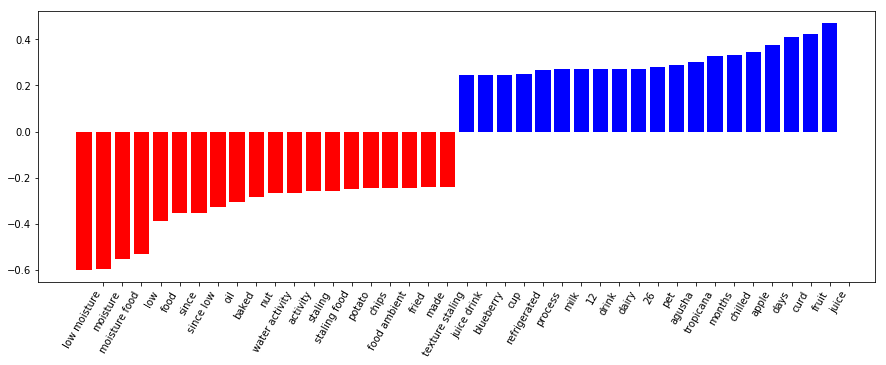

In [340]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer


def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()


tfidf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2))
features = tfidf.fit_transform(X)

nb = MultinomialNB()
nb.fit(features, y)
print("after fit")
plot_coefficients(svm, tfidf.get_feature_names())

This shows words like 'low moisture', 'oil','baked','water activity' point to a prediction of No in potential Microbial <br>
Words like 'juice','fruit','curd','chilled','dairy' points to a prediction of 'Yes' in potential microbial activity

# Let us plot the Confustion matrix for potential Microbial prediction

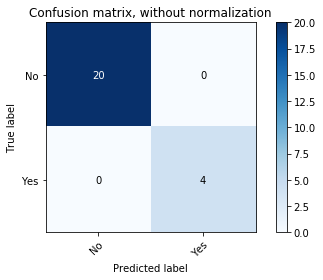

In [342]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
   # else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names=['No','Yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [350]:
X = X.reshape(X.shape[0],)
y = y.reshape(y.shape[0],)

# In order to validate the results let us do K-fold CV with K set to 5

In [390]:
nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
cv_results = cross_validate(nb.fit(X, y), X, y,cv=5)

In [391]:
print(cv_results['test_score'])

[1.   0.97 1.   1.   1.  ]


This shows a healthy score in all folds <br>
Let us investigate the False Positives and False Negatives in the folds

In [394]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit
#We define custom functions to return count of TP,TN,FP,FN for each fold
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), 'fn': make_scorer(fn)}
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
cv_results = cross_validate(nb.fit(X, y), X, y,scoring=scoring, cv=cv)

In [395]:
print("Count of True Positives")
print(cv_results['test_tp']) 
print("Count of True Negatives")
print(cv_results['test_tn']) 
# Getting the test set false negative scores
print("Count of False Negatives")
print(cv_results['test_fn']) 
print("Count of False Positives")
print(cv_results['test_fp']) 

Count of True Positives
[18 14 17 14 18]
Count of True Negatives
[18 21 19 22 18]
Count of False Negatives
[0 0 0 0 0]
Count of False Positives
[0 1 0 0 0]


# We can fine tune the parameters of Model using GridSearch, though in this case the default settings are giving use high accuracy

In [369]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',MultinomialNB() ),
])
#

In [371]:
parameters = {
    'vect__max_df': ( 0.75, 1.0),
    'vect__min_df': ( 1, 2),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
   # 'clf__max_iter': (20,),
    'clf__alpha': (1, 0.8),
    #'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}
# multiprocessing requires the fork to happen in a __main__ protected
# block

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X, y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1, 0.8),
 'vect__max_df': (0.75, 1.0),
 'vect__min_df': (1, 2),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   30.9s finished


done in 31.735s

Best score: 0.994
Best parameters set:
	clf__alpha: 1
	vect__max_df: 0.75
	vect__min_df: 1
	vect__ngram_range: (1, 2)


# Let us check a few other models and evaluate the accuracy

### SGDClassifier

In [362]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [363]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 1.0
f1-score 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        20
          1       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00        24

Wall time: 0 ns


### Logistic regression

In [364]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [365]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 1.0
f1-score 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        20
          1       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00        24

Wall time: 15.6 ms


In [367]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=7)

lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),])
cv_results = cross_validate(lr.fit(X, y), X, y,scoring=scoring, cv=cv)

In [368]:
print("Count of True Positives")
print(cv_results['test_tp']) 
print("Count of True Negatives")
print(cv_results['test_tn']) 
# Getting the test set false negative scores
print("Count of False Negatives")
print(cv_results['test_fn']) 
print("Count of False Positives")
print(cv_results['test_fp']) 

Count of True Positives
[12 17 18 22 17]
Count of True Negatives
[23 19 18 14 18]
Count of False Negatives
[0 0 0 0 0]
Count of False Positives
[1 0 0 0 1]


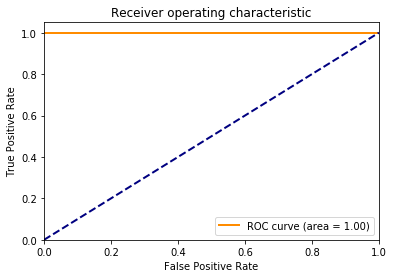

In [366]:
from sklearn.metrics import roc_curve, auc
true_labels = y_test
scores = y_pred

# compute fpr, tpr, thresholds and roc_auc
fpr, tpr, thresholds = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr) # compute area under the curve
 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# We find the both Target Yes and No is predicted with 100% accuracy, with the Bag of Words, TF-IDF Vectorization and Multinomial Naive Bayes model. We plot the feature importance and analyse the features that lead to prediction of Yes vs No in Microbial Activity. We check the Confusion Matrix, ROC-AUC, and test few Predictive Models like Logistic Regression, SGDClassifier. The results of K-fold CV shows a minor problem with 1 False Negative reported in some of the folds. This proves ML Model is working with the prediction for potentialMicrobial and NAF Data